<a href="https://colab.research.google.com/github/kaylynrmd/Predictive-Analytics-Project/blob/main/notebooks/05_modeling_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Advanced Model: Random Forest + Model Comparison

This notebook trains a more flexible model (Random Forest) to predict customer churn.
Random Forest can capture non-linear relationships and interactions that Logistic Regression may miss.

This notebook includes:
- Random Forest training
- Hyperparameter tuning (RandomizedSearchCV)
- Evaluation metrics and ROC-AUC
- Comparison to the baseline Logistic Regression
- Feature importance + business insights


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import kagglehub
import os

path = kagglehub.dataset_download("blastchar/telco-customer-churn")
files = os.listdir(path)
df = pd.read_csv(os.path.join(path, files[0]))

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

df.head()


Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

y.value_counts(normalize=True)


,proportion
Churn,
0,0.73463
1,0.26537


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [6]:
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


Rebuild Baseline

In [7]:
lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

lr_auc = roc_auc_score(y_test, lr_prob)
lr_auc


np.float64(0.8418610659019866)

Random Forest

In [8]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

rf_auc = roc_auc_score(y_test, rf_prob)
rf_auc


np.float64(0.8216732542819498)

In [9]:
print(classification_report(y_test, rf_pred))


              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.62      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



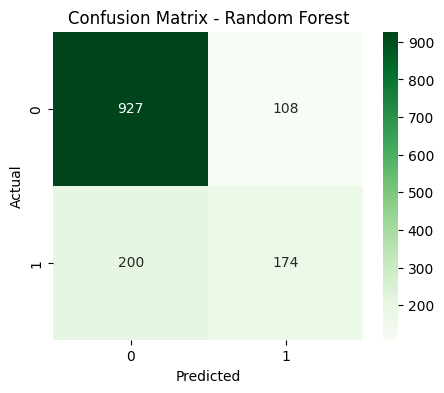

In [10]:
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


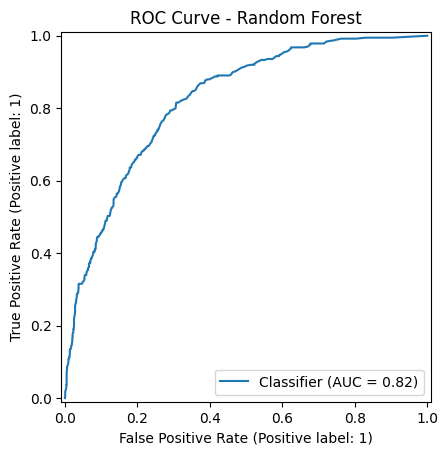

In [11]:
RocCurveDisplay.from_predictions(y_test, rf_prob)
plt.title("ROC Curve - Random Forest")
plt.show()


Hyperparameter Tuning

In [12]:
param_dist = {
    "classifier__n_estimators": [200, 300, 500],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

rf_tune = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

search = RandomizedSearchCV(
    rf_tune,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

search.best_params_


{'classifier__n_estimators': 500,
 'classifier__min_samples_split': 5,
 'classifier__min_samples_leaf': 4,
 'classifier__max_depth': 10}

In [14]:
best_rf = search.best_estimator_

best_pred = best_rf.predict(X_test)
best_prob = best_rf.predict_proba(X_test)[:, 1]

best_auc = roc_auc_score(y_test, best_prob)
best_auc


np.float64(0.8414671006742617)

In [15]:
print(classification_report(y_test, best_pred))


              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.75      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



Model Comparison

In [16]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Tuned Random Forest"],
    "ROC-AUC": [lr_auc, rf_auc, best_auc]
})

results


,Model,ROC-AUC
0,Logistic Regression,0.841861
1,Random Forest,0.821673
2,Tuned Random Forest,0.841467


<Figure size 600x500 with 0 Axes>

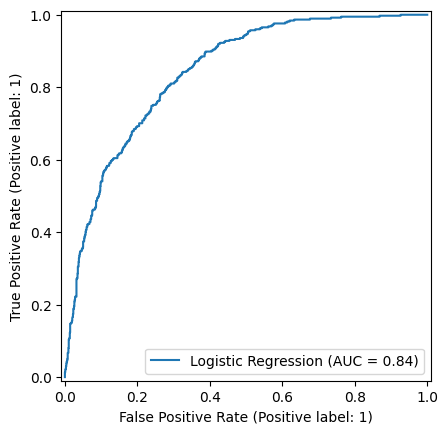

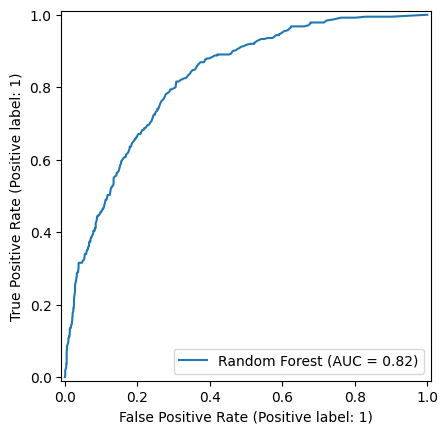

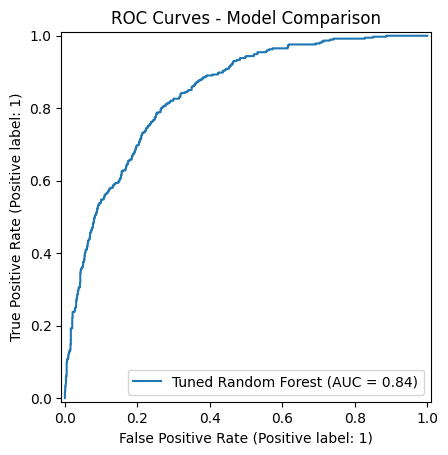

In [17]:
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, lr_prob, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, rf_prob, name="Random Forest")
RocCurveDisplay.from_predictions(y_test, best_prob, name="Tuned Random Forest")
plt.title("ROC Curves - Model Comparison")
plt.show()


Feature Importance

In [18]:
# Get the fitted preprocessor from best_rf
fitted_preprocessor = best_rf.named_steps["preprocessor"]
rf_clf = best_rf.named_steps["classifier"]

# Feature names
ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_clf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(15)


,feature,importance
36,Contract_Month-to-month,0.129255
1,tenure,0.121289
3,TotalCharges,0.098323
2,MonthlyCharges,0.067645
38,Contract_Two year,0.065361
18,OnlineSecurity_No,0.061038
27,TechSupport_No,0.057788
16,InternetService_Fiber optic,0.048215
43,PaymentMethod_Electronic check,0.033174
37,Contract_One year,0.020744


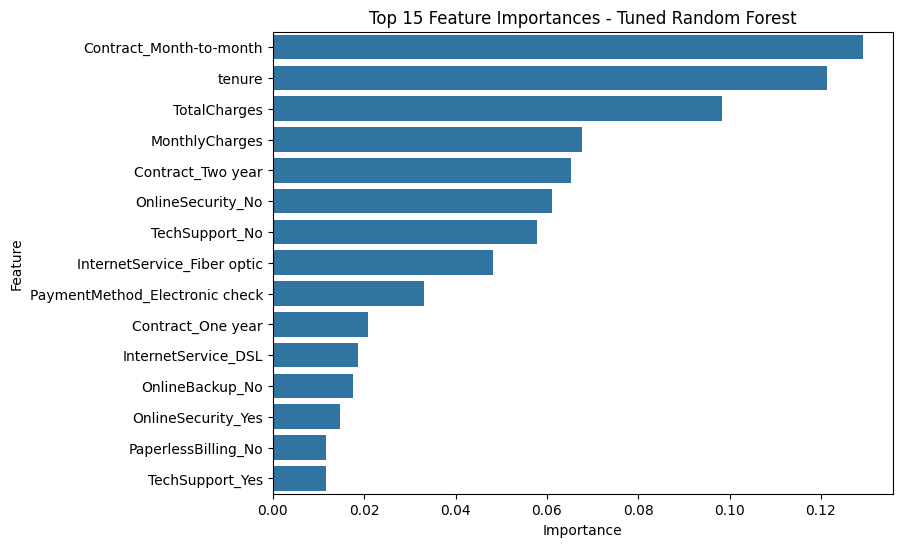

In [19]:
top_n = 15
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(top_n), x="importance", y="feature")
plt.title(f"Top {top_n} Feature Importances - Tuned Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [20]:
## Business Insights (Based on Model + Feature Importance)

The advanced model suggests churn is most strongly influenced by a combination of contract structure, tenure, and billing factors.

Key actionable takeaways:
- Customers on month-to-month contracts show elevated churn risk. Incentives to move these customers to longer-term contracts may reduce churn.
- Short-tenure customers are consistently high risk, suggesting the first 3–12 months are critical for retention outreach.
- Higher monthly charges and certain service combinations appear linked to churn, which may reflect perceived value concerns or pricing sensitivity.

Overall, the model supports targeting retention strategies toward early-lifecycle customers and month-to-month subscribers.


SyntaxError: invalid character '–' (U+2013) (ipython-input-1534283026.py, line 7)

In [ ]:
## Ethical Considerations & Limitations

Ethics:
- Churn predictions should be used to improve customer experience (support, proactive outreach), not to penalize or discriminate against customers.
- Some variables may act as proxies for sensitive attributes (e.g., pricing level or service type could correlate with income). Organizations should monitor for unfair impact.

Limitations:
- This dataset represents a snapshot in time and may not reflect future behavior if pricing, services, or customer demographics change.
- The dataset does not capture customer sentiment or service quality issues directly, which could improve prediction if available.
- Model performance may degrade over time (model drift), so ongoing monitoring and retraining would be required in a real deployment.
